In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
from pymatgen.io.cif import CifParser
import matplotlib.pyplot as plt

In [2]:
kB = 1.380649e-23
NA = 6.02214076e23

plt.rcParams.update({'text.usetex':True, 
'font.family':'serif', 
'font.size':18, 
})

colors = sns.color_palette("mako")

class Framework:

    def __init__(self, cif_path):  

        # Define all geometric information of the framework
        self.cif_path = cif_path
        self.cif_parser = CifParser(self.cif_path, occupancy_tolerance=100)
        self.structure_adsorbent = self.cif_parser.parse_structures(primitive=False)[0]
        self.volume_cell = self.structure_adsorbent.volume
        self.get_lattice_and_coordinates()
        self.get_system_size()
        self.angles = np.array([self.alpha_deg, self.beta_deg, self.gamma_deg])
        self.num_atoms = self.coordinates.shape[0]

    def get_lattice_and_coordinates(self):
        # Get the coordinates of each atom
        # dic = self.cif_parser.as_dict()
        # dic = dic[list(dic.keys())[0]]
        self.a = self.structure_adsorbent.lattice.a
        self.b = self.structure_adsorbent.lattice.b
        self.c = self.structure_adsorbent.lattice.c
        self.alpha_rad = self.structure_adsorbent.lattice.angles[0]*np.pi/180.
        self.beta_rad = self.structure_adsorbent.lattice.angles[1]*np.pi/180.
        self.gamma_rad = self.structure_adsorbent.lattice.angles[2]*np.pi/180.
        self.alpha_deg = self.structure_adsorbent.lattice.angles[0]
        self.beta_deg = self.structure_adsorbent.lattice.angles[1]
        self.gamma_deg = self.structure_adsorbent.lattice.angles[2]
        self.lattice = self.get_lattice_RASPA()
        self.frac_coordinates = (self.structure_adsorbent.frac_coords)
        self.coordinates = (self.structure_adsorbent.frac_coords)@self.lattice 
        
    def get_lattice_RASPA(self):
        # This function calculates the lattice like RASPA because it is 
        # different from the one in pymatgen
        zeta = (np.cos(self.alpha_rad)-np.cos(self.gamma_rad)*np.cos(self.beta_rad))/np.sin(self.gamma_rad)
        lat_test = np.array([
            [self.a, self.b*np.cos(self.gamma_rad), self.c*np.cos(self.beta_rad)],
            [0, self.b*np.sin(self.gamma_rad), self.c*zeta],
            [0, 0, self.c*np.sqrt(1 - np.cos(self.beta_rad)**2 - zeta**2)]])
        return lat_test.T

    def get_system_size(self):
        # Get the size of the cell.
        self.system_size = [l for l in self.structure_adsorbent.lattice.lengths]
        self.system_size = np.array(self.system_size)

def pore(structure):

    forcefield = pd.DataFrame()
    forcefield['type'] = ['C','H','O','Zn']
    forcefield['mass'] = np.array([12.000, 1.0000, 15.999, 65.37]) 

    mass = 0.0

    for k, site in enumerate(structure.structure_adsorbent):
        atom_idx = forcefield["type"]==site.species_string
        mass += float(forcefield["mass"][atom_idx].iloc[0])

    return mass

In [3]:
MM = 15.999*2+12.0
framework_name = 'IRMOF-1'
structure = Framework(f'{framework_name}.cif')
T = 195.0

exp_data = pd.read_csv('CO2_IRMOF-1_195K_exp_ads.csv', skiprows=11)
exp_data['pressure'] = exp_data['pressure']*0.1333223684
exp_data['total_adsorption'] = exp_data['total_adsorption']/MM

pressure = np.array([  1000.0000,   1599.8684,   5332.8947,   9865.8553, 
                         11920.0, 12946., 13972.1842, 15492.0592, 16705.2928,  
                         18078.5132,  19331.7434,  19998.3553, 20664.9671,  21998.1908,  
                         23331.4145,  25331.2500,  28664.3092, 33330.5921,  40130.0329])

/home/lucas/miniforge3/envs/torch/lib/python3.14/site-packages/pymatgen/io/cif.py:1029: UserWarning: No _symmetry_equiv_pos_as_xyz type key found. Spacegroup from _symmetry_space_group_name_H-M used.
  self.symmetry_operations = self.get_symops(data)  # type:ignore[assignment]
/home/lucas/miniforge3/envs/torch/lib/python3.14/site-packages/pymatgen/io/cif.py:1314: UserWarning: Cannot determine chemical composition from CIF! _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _a _b _b _b _b _b _b _b _b _b _b _b _b _b _b _b 

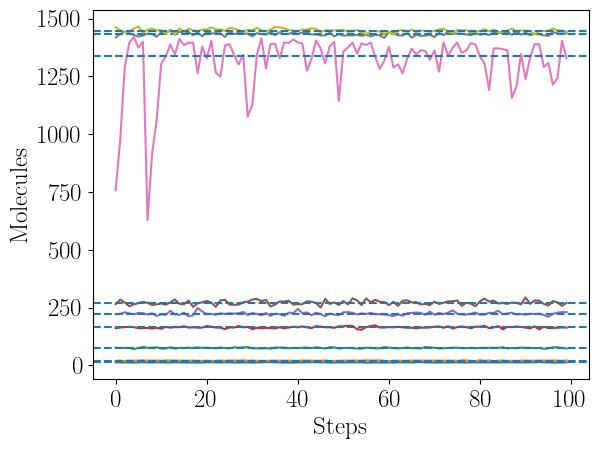

In [10]:
points = 9

Nads = np.zeros_like(pressure)     
Lz = np.zeros_like(pressure)   
strain = np.zeros_like(pressure)  
volume_mean = np.zeros_like(pressure)  
volume_var = np.zeros_like(pressure)  

framework_mass = pore(structure)
V0 = 5.16965**3

for i in range(points):

    df = pd.read_csv(f'pressure_{1e-3*pressure[i]:.2f}_kPa/output.csv')

    plt.plot(df.index.values,df.molecules.values,'-')
    plt.axhline(y=df.molecules[10:].mean(), linestyle="--", linewidth=1.5)
    plt.xlabel("Steps")
    plt.ylabel("Molecules")

    Nads[i] = df.molecules[10:].values.mean() 
    Lz[i] = (df.Lz.values[10:].mean())
    volume_mean[i] = 1e-27*df.volumes_mean.values[10:].mean() 
    volume_var[i] = 1e-54*df.volumes_var.values[10:].mean()  
    strain[i] = ((df.Lz.values**3-V0)/V0).mean() 